## Uber supply demand gap analysis for India region.

Major issues impacting Uber's business are:

* Cancellation of rides going towards the airport were higher than regular trips. 
* Trips to and from an airport resulted in high consumption of fuel and time. Hence, a trip back to the city without a rider is not economically beneficial for the driver. 
* Due to high variance in flight arrivals (higher during evening, late night hours) the driver idle time is higher in morning. As a result, no cars are available during peak night       hours because working hours ends for majority drivers at night.

Exploratory data analysis(EDA) is done on a masked dataset to draw some useful insights from the data using standard python libraries like:

* NumPy
* Pandas
* Matplotlib

As part of EDA I have followed below steps:

1. Data Extraction: Load the data set and inspect different features.
2. Data Cleaning: Correcting datetime formats and filling in missing values.
3. Feature Engineering: Determine new features.
4. Plotting: Create plots to see correlation between data points and draw important insights out of data.

### Data Extraction

Importing useful libraries.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Loading the dataset from csv to pandas data frame.

In [58]:
uberdata = pd.read_csv("Uber Request Data.csv")

Analyzing different columns in dataset.

In [59]:
uberdata.head()

Request id Pickup point  Driver id          Status    Request timestamp  \
0         619      Airport        1.0  Trip Completed      11/7/2016 11:51   
1         867      Airport        1.0  Trip Completed      11/7/2016 17:57   
2        1807         City        1.0  Trip Completed       12/7/2016 9:17   
3        2532      Airport        1.0  Trip Completed      12/7/2016 21:08   
4        3112         City        1.0  Trip Completed  13-07-2016 08:33:16   

        Drop timestamp  
0      11/7/2016 13:00  
1      11/7/2016 18:47  
2       12/7/2016 9:58  
3      12/7/2016 22:03  
4  13-07-2016 09:25:47

In [60]:
uberdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


We can see that `Request timestamp` and `Drop timestamp` are not in consistent datetime format.

### Data Cleaning

Check for duplicate rows.

In [61]:
sum(uberdata.duplicated(subset = "Request id")) == 0

True

Check dimensions of data frame.

In [62]:
uberdata.shape

(6745, 6)

Checking null values in data frame.

In [63]:
print (uberdata.isnull().sum())  
print (uberdata.isnull().values.any())
print (uberdata.isnull().values.sum())

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64
True
6564


Calculating null percentages column wise.

In [64]:
pd.DataFrame(round((100*(uberdata.isnull().sum()/len(uberdata.index))),2))

0
Request id          0.00
Pickup point        0.00
Driver id          39.29
Status              0.00
Request timestamp   0.00
Drop timestamp     58.03

We can see that Drop timestamp and Driver ID have considerable null values, these entries are probably the rides where trip was never assigned to a driver and it was not completed (Status - 'No cars available').

Calculating count of row wise null values.

In [65]:
pd.DataFrame(uberdata.isnull().sum(axis=1))

0
0     0
1     0
2     0
3     0
4     0
...  ..
6740  2
6741  2
6742  2
6743  2
6744  2

[6745 rows x 1 columns]

Converting format of `Request timestamp` and `Drop timestamp` columns to datetime object.

In [66]:
uberdata['Request timestamp'] = pd.to_datetime(uberdata['Request timestamp'])
uberdata['Drop timestamp'] = pd.to_datetime(uberdata['Drop timestamp'])
uberdata[['Request id','Request timestamp','Drop timestamp']].head(3)

Request id   Request timestamp      Drop timestamp
0         619 2016-11-07 11:51:00 2016-11-07 13:00:00
1         867 2016-11-07 17:57:00 2016-11-07 18:47:00
2        1807 2016-12-07 09:17:00 2016-12-07 09:58:00

In [67]:
uberdata['Request timestamp'].max()

Timestamp('2016-12-07 23:54:00')

Checking validity of types of other columns in the data set.

In [68]:
uberdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Request id         6745 non-null   int64         
 1   Pickup point       6745 non-null   object        
 2   Driver id          4095 non-null   float64       
 3   Status             6745 non-null   object        
 4   Request timestamp  6745 non-null   datetime64[ns]
 5   Drop timestamp     2831 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 316.3+ KB


<br></br>
### Feature Engineering

Adding new columns `Request Hours` and `Drop Hours` to the dataset by extracting hours from `Request timestamp` and `Drop timestamp` columns.

In [69]:
uberdata['Request Hours'] = uberdata['Request timestamp'].apply(lambda x:x.hour)
uberdata['Drop Hours'] = uberdata['Drop timestamp'].apply(lambda x: x.hour)
uberdata[['Request id','Request timestamp','Drop timestamp','Request Hours','Drop Hours']].head(5)

Request id   Request timestamp      Drop timestamp  Request Hours  \
0         619 2016-11-07 11:51:00 2016-11-07 13:00:00             11   
1         867 2016-11-07 17:57:00 2016-11-07 18:47:00             17   
2        1807 2016-12-07 09:17:00 2016-12-07 09:58:00              9   
3        2532 2016-12-07 21:08:00 2016-12-07 22:03:00             21   
4        3112 2016-07-13 08:33:16 2016-07-13 09:25:47              8   

   Drop Hours  
0        13.0  
1        18.0  
2         9.0  
3        22.0  
4         9.0

Adding new column `Request Time Slot` to each request according to the time range defined below:

* [0hours-8hours)- Early Morning
* [8hours-12hours)- Peak morning hours
* [12hours-17hours) Noon hours
* [17hours-21hours)- Evening hours 
* [21hours<]- Night Hours

In [70]:
def determine_time_slot(x):
    if (x >=0 and x < 8):
        return "Early morning hours"    #12am-7am
    elif (x >= 8 and x < 12):
        return "Peak morning hours"     #8am-11am
    elif (x >= 12 and x < 17):
        return "Noon hours"             #12pm-4pm
    elif (x >= 17 and x < 21):
        return "Evening hours"          #5pm-8pm
    elif (x >= 21):
        return "Night hours"            #9pm onwards

    
uberdata['Request Time Slot'] = uberdata['Request Hours'].apply(determine_time_slot)
uberdata[['Request id','Pickup point','Request Time Slot']].head(5)

Request id Pickup point   Request Time Slot
0         619      Airport  Peak morning hours
1         867      Airport       Evening hours
2        1807         City  Peak morning hours
3        2532      Airport         Night hours
4        3112         City  Peak morning hours

Count number of requests for each request time slot.

In [71]:
uberdata['Request Time Slot'].value_counts()

Evening hours          1893
Early morning hours    1827
Peak morning hours     1268
Night hours             947
Noon hours              810
Name: Request Time Slot, dtype: int64

Maximum requests were made in evening hours and early morning hours.

### Plotting and observations

Plotting `Request Hours` to see the trend of request during different hours of the day for each status.

Text(0, 0.5, 'Count of requests')

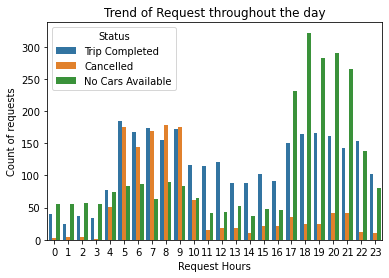

In [72]:
sns.countplot(x="Request Hours",hue="Status",data = uberdata)
plt.title('Trend of Request throughout the day')
plt.ylabel('Count of requests')

Plotting `Status` column for determining frequency of trips with cancelled, no cars available and trip completed status.

Text(0, 0.5, 'Trip count')

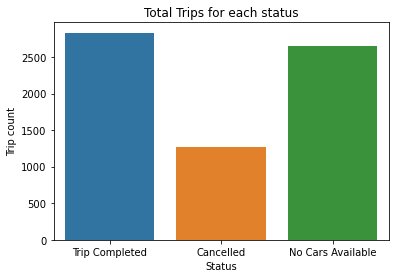

In [73]:
sns.countplot(x="Status",data = uberdata)
plt.title('Total Trips for each status')
plt.ylabel('Trip count')

From the above count plot we can conclude that, almost an equal number of request ends with the status of either `No Cars Available` or  `Trips Completed`.

<br></br>
Determine the most problematic pickup point for all request status.

Text(0, 0.5, 'Airport/City trip count')

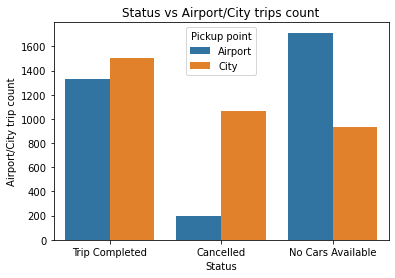

In [74]:
sns.countplot(x="Status",hue="Pickup point",data = uberdata)
plt.title('Status vs Airport/City trips count')
plt.ylabel('Airport/City trip count')

* <b>'No cars available'</b> - Between 1600-1700 no of trips where pickup point is 'Airport' uber customers didn't get the car.
* <b>'Trip Completed'</b> - Between 1400-1500 no of trips were completed where pickup point is city and around 1300 trips were completed for Airport           pickup point. 
* <b>'Cancelled'</b> - Between 1000-1050 no of trips were cancelled as well where pick up point is city which is a little less than trips completed where pick up point is city.

<br></br>
Determine time slots when maximum trips were completed/cancelled/no cars available.

Text(0.5, 0, 'Status count')

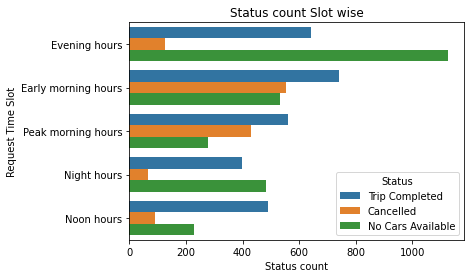

In [75]:
sns.countplot(y="Request Time Slot",hue="Status",data = uberdata,
              order = uberdata['Request Time Slot'].value_counts().index)
plt.title('Status count Slot wise')
plt.xlabel('Status count')

Key highlihts from above plot:
* <b>Evening hours</b> (5pm-8pm): No of requests between 1000-1200 ended with no cars available.
* <b>Early morning hours</b> (1am-7am): No of requests between 500-600 were cancelled and cars were not available.
* <b>Early morning hours</b> (1am-7am): Approx 700-800 no of trips were completed.

<br></br>
To analyze plots for each trip status, creating individual data frames.

In [76]:
df_nocars = uberdata[(uberdata['Status'] == 'No Cars Available')]
df_tripcompl = uberdata[(uberdata['Status'] == 'Trip Completed')]
df_canceled = uberdata[(uberdata['Status'] == 'Cancelled')]

<br></br>
<b>`No cars available`:</b> Airport and city pickup points counts for all time slots.

Text(0.5, 0, 'Airport/City count')

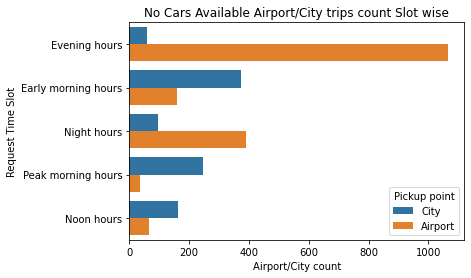

In [77]:
sns.countplot(y="Request Time Slot",hue="Pickup point",data = df_nocars,order = df_nocars['Request Time Slot'].value_counts().index)
plt.title('No Cars Available Airport/City trips count Slot wise')
plt.xlabel('Airport/City count')

* For airport pickups during evening hours(5pm - 8pm) maximum request ended up with no cars available (1100 - 1200).
* For city pickups during early morning hours(1am - 7am) maximum request ended up with no cars available (350-400).

Count of airport rides in evening hours where cars were not available.

In [78]:
df_nocars_airport = df_nocars.loc[(df_nocars['Pickup point']=='Airport') & (df_nocars['Request Time Slot']=='Evening hours')]
len(df_nocars_airport.index)

1067

Count of city rides in early morning hours where cars were not available.

In [79]:
df_nocars_city = df_nocars.loc[(df_nocars['Pickup point']=='City') & (df_nocars['Request Time Slot']=='Early morning hours')]
len(df_nocars_city.index)

374

<br></br>
<b>`Trip Completed`:</b> Airport and city pickup points counts for all time slots.

Text(0.5, 0, 'Airport/City count')

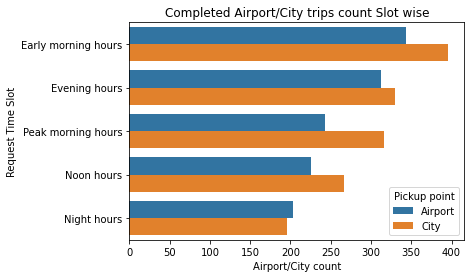

In [80]:
sns.countplot(y="Request Time Slot",hue="Pickup point",data = df_tripcompl,order=df_tripcompl['Request Time Slot'].value_counts().index)
plt.title('Completed Airport/City trips count Slot wise')
plt.xlabel('Airport/City count')

* For city pickups maximum trips were completed during early morning hours 1am- 7am (approx 400).
* For airport pickups maximum trips were completed during early morning hours only 1am-7am (approx 340).

Count of city rides in early morning hours where trips were completed.

In [81]:
df_tripcompl_city = df_tripcompl.loc[(df_tripcompl['Pickup point']=='City') & (df_tripcompl['Request Time Slot']=='Early morning hours')]
len(df_tripcompl_city.index)

396

Count of airport rides in early morning hours where trips were completed.

In [82]:
df_tripcompl_airport = df_tripcompl.loc[(df_tripcompl['Pickup point']=='Airport') & (df_tripcompl['Request Time Slot']=='Early morning hours')]
len(df_tripcompl_airport.index)

344

<br></br>
<b>`Cancelled`:</b> Airport and city pickup points counts for all time slots.

Text(0.5, 0, 'Airport/City count')

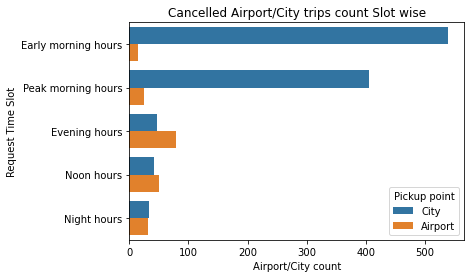

In [83]:
sns.countplot(y="Request Time Slot",hue="Pickup point",data = df_canceled,order=df_canceled['Request Time Slot'].value_counts().index)
plt.title('Cancelled Airport/City trips count Slot wise')
plt.xlabel('Airport/City count')

* For city pickups maximum trips were canceled during early morning hours of 1am - 7am (approx 500-600).
* For airport pickups maximum trips were canceled during evening hours of 5pm-8pm (approx 50-90).

Count of city rides in early morning hours where requests were cancelled by drivers.

In [84]:
df_cancelled_city = df_canceled.loc[(df_canceled['Pickup point']=='City') & (df_canceled['Request Time Slot']=='Early morning hours')]
len(df_cancelled_city.index)

540

Count of airport rides in evening hours where requests were cancelled by drivers.

In [85]:
df_cancelled_airport = df_canceled.loc[(df_canceled['Pickup point']=='Airport') & (df_canceled['Request Time Slot']=='Evening hours')]
len(df_cancelled_airport.index)

78

<br></br>
<b>Total requests for each trip status.</b>

In [86]:
print("Total requests where cars were not available :"+str(len(df_nocars.index)))
print("Total requests which were cancelled :"+str(len(df_canceled.index)))
print("Total requests which were Completed :"+str(len(df_tripcompl.index)))

Total requests where cars were not available :2650
Total requests which were cancelled :1264
Total requests which were Completed :2831


<br></br>

<b>Calculating demand-supply metrics.</b>
* <b>Total Demand :</b> Total trips made with all three status.
* <b>Total Suply :</b> Total number of trips completed.
* <b>Gap :</b> Difference between total demand and supply.

In [87]:
demand = len(df_nocars.index) + len(df_canceled.index) + len(df_tripcompl.index)
print("Total Demand :"+str(demand))

supply = len(df_tripcompl.index)
print("Total Supply :"+str(supply))

gap = demand - supply
print("Total Gap :"+str(gap))

Total Demand :6745
Total Supply :2831
Total Gap :3914


<br></br>
Plotting number of requests for each request time slot to see the demand across time slots.

Text(0.5, 0, 'Demand Count')

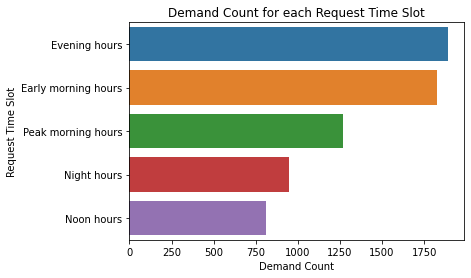

In [88]:
sns.countplot(y="Request Time Slot",data = uberdata,order=uberdata['Request Time Slot'].value_counts().index)
plt.title('Demand Count for each Request Time Slot')
plt.xlabel('Demand Count')


Demand for all time slots.
* 0 - 8 - Early morning hours - approx 1800-1900
* 8 - 12 - Peak morning hours - approx 1250-1300
* 12 - 17 - Noon hours - approx 750-850
* 17 - 21 - Evening hours - approx 1800-2000
* 21 - 23 - Night hours - approx 700-750

In [89]:
len(uberdata.loc[(uberdata['Request Time Slot'] == 'Evening hours')].index)

1893

We can infer that maximum demand is during evening hours between 5PM-8PM.
<br></br>

<b>Plotting number of requests for each time slot only where trip was completed</b>.

Text(0.5, 0, 'Supply Count')

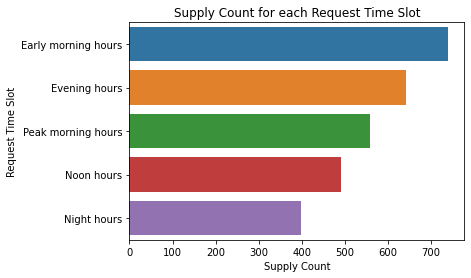

In [90]:
sns.countplot(y="Request Time Slot",data = df_tripcompl,order=df_tripcompl['Request Time Slot'].value_counts().index)
plt.title('Supply Count for each Request Time Slot')
plt.xlabel('Supply Count')

Supply for all request time slots.
* 0 - 8 - Early Morning hours - approx 700-750
* 8 - 12 - Peak morning hours - approx 500-550
* 12 - 17 - Noon hours - approx 450-500
* 17 - 21 - Evening hours - approx 600-650
* 21 - 23 - Night Hours - approx 250-300

In [91]:
len(df_tripcompl.loc[(df_tripcompl['Request Time Slot'] == 'Early morning hours')].index)

740

We can infer that maximum supply is in early morning hours between 1am - 7am.
<br></br>

<b>From the above plots we can conclude that their is an imbalance between demand and supply. Hence, now calculating demand-supply metrics for both airport and city requets for all requests time slots</b>

Creating two seperate data frames for Airport and city rides.

In [92]:
df_airport_request = uberdata.loc[uberdata['Pickup point']=='Airport']
df_city_request = uberdata.loc[uberdata['Pickup point']=='City']

In [93]:
def calculateDemandSupply(dataframe,timeSlot):
    demand = dataframe[(dataframe['Request Time Slot'] == timeSlot)]['Request id'].count()
    supply = dataframe[(dataframe['Request Time Slot'] == timeSlot) & (dataframe['Status'] == 'Trip Completed')]['Request id'].count()
    gap = demand-supply
    
    return demand,supply,gap

<br></br>
<b>Demand-supply metrics for Airport rides for all time slots.</b>

In [94]:
demand_earlymorning_a,supply_earlymorning_a,gap_earlymorning_a = calculateDemandSupply(df_airport_request,'Early morning hours') #Early morning hours
demand_peakmorning_a,supply_peakmorning_a,gap_peakmorning_a = calculateDemandSupply(df_airport_request,'Peak morning hours') #Peak morning hours
demand_noon_a,supply_noon_a,gap_noon_a = calculateDemandSupply(df_airport_request,'Noon hours') #Noon hours
demand_evening_a,supply_evening_a,gap_evening_a = calculateDemandSupply(df_airport_request,'Evening hours') #Evening hours
demand_night_a,supply_night_a,gap_night_a = calculateDemandSupply(df_airport_request,'Night hours') #Night hours

<br></br><b>Demand-supply metrics for City rides for all time slots.</b>

In [95]:
demand_earlymorning_c,supply_earlymorning_c,gap_earlymorning_c = calculateDemandSupply(df_city_request,'Early morning hours') #Early morning hours
demand_peakmorning_c,supply_peakmorning_c,gap_peakmorning_c = calculateDemandSupply(df_city_request,'Peak morning hours') #Peak morning hours
demand_noon_c,supply_noon_c,gap_noon_c = calculateDemandSupply(df_city_request,'Noon hours') #Noon hours
demand_evening_c,supply_evening_c,gap_evening_c = calculateDemandSupply(df_city_request,'Evening hours') #Evening hours
demand_night_c,supply_night_c,gap_night_c = calculateDemandSupply(df_city_request,'Night hours') #Night hours

<br></br>
<b>Calculating total demand and supply for all time slots</b>

In [96]:
#Total demand
demand_earlymorning = demand_earlymorning_a + demand_earlymorning_c
demand_peakmorning = demand_peakmorning_a + demand_peakmorning_c
demand_noon = demand_noon_a + demand_noon_c
demand_evening = demand_evening_a + demand_evening_c
demand_night = demand_night_a + demand_night_c

#Total Supply
supply_earlymorning = supply_earlymorning_a + supply_earlymorning_c
supply_peakmorning = supply_peakmorning_a + supply_peakmorning_c
supply_noon = supply_noon_a + supply_noon_c
supply_evening = supply_evening_a + supply_evening_c
supply_night = supply_night_a + supply_night_c

#Total gap
gap_earlymorning = demand_earlymorning-supply_earlymorning
gap_peakmorning = demand_peakmorning-supply_peakmorning
gap_noon = demand_noon-supply_noon
gap_evening = demand_evening-supply_evening
gap_night = demand_night-supply_night

<br></br>
<b>Plotting count of trip for all request time slots corresponding to Airport and City pickup points.</b>

Text(0, 0.5, 'Airport/City request count')

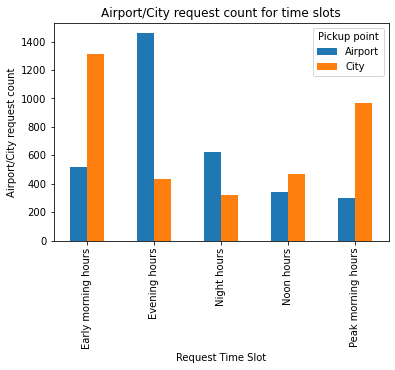

In [97]:
uberdata.groupby(['Request Time Slot','Pickup point']).size().unstack().plot(kind='bar',stacked=False)
plt.title('Airport/City request count for time slots')
plt.ylabel('Airport/City request count')

Conclusions:
* Maximum trip requests from Airport were made in evening hours.
* Maximum trip requests from City were made in early morning hours.

Creating a new gap data frame with demand-supply counts for all time slots.

In [98]:
gap_data = { 'Request Time Slot': ['Early morning','Peak morning','Noon','Evening','Night'] , 
             'Total Demand': [demand_earlymorning,demand_peakmorning,demand_noon,demand_evening,demand_night],
             'Total Supply': [supply_earlymorning,supply_peakmorning,supply_noon,supply_evening,supply_night],
             'Total Gap': [gap_earlymorning,gap_peakmorning,gap_noon,gap_evening,gap_night],
             'Demand_From_Airport': [demand_earlymorning_a,demand_peakmorning_a,demand_noon_a,demand_evening_a,demand_night_a],
            'Supply_To_Airport':[supply_earlymorning_a,supply_peakmorning_a,supply_noon_a,supply_evening_a,supply_night_a],
            'Gap_From_Airport': [gap_earlymorning_a,gap_peakmorning_a,gap_noon_a,gap_evening_a,gap_night_a],
            'Demand_From_City': [demand_earlymorning_c,demand_peakmorning_c,demand_noon_c,demand_evening_c,demand_night_c],
            'Supply_To_City':[supply_earlymorning_c,supply_peakmorning_c,supply_noon_c,supply_evening_c,supply_night_c],
            'Gap_From_City': [gap_earlymorning_c,gap_peakmorning_c,gap_noon_c,gap_evening_c,gap_night_c]}

gap_df = pd.DataFrame(data=gap_data)

Viewing gap data frame

In [99]:
gap_df

Request Time Slot  Total Demand  Total Supply  Total Gap  \
0     Early morning          1827           740       1087   
1      Peak morning          1268           559        709   
2              Noon           810           491        319   
3           Evening          1893           642       1251   
4             Night           947           399        548   

   Demand_From_Airport  Supply_To_Airport  Gap_From_Airport  Demand_From_City  \
0                  517                344               173              1310   
1                  301                243                58               967   
2                  339                225               114               471   
3                 1457                312              1145               436   
4                  624                203               421               323   

   Supply_To_City  Gap_From_City  
0             396            914  
1             316            651  
2             266            205  
3             330            106  
4             196            127

<b>Plotting demand-supply gap for all requests time slots.</b>

Text(0.5, 6.79999999999999, 'Total Gap')

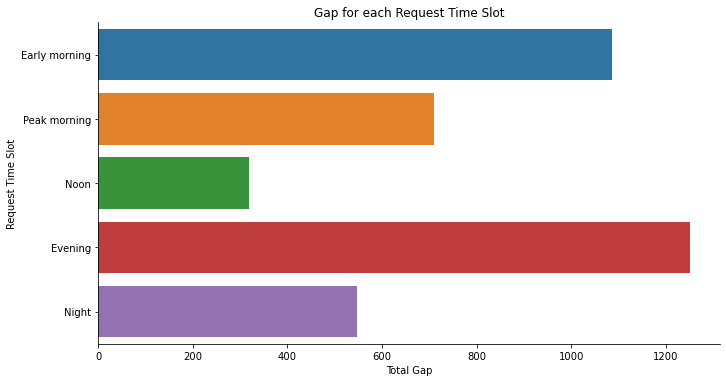

In [100]:
sns.catplot(x="Total Gap",y="Request Time Slot",kind="bar",data = gap_df,height = 5,aspect=2)
plt.title('Gap for each Request Time Slot')
plt.xlabel('Total Gap')

Conclusion:
* Demand-supply gap is maximum for evening hours.
* Demand-supply gap is minimum for noon hours.
<br></br>

<b>Visualizing gap differentiated by pickup points and all time slots.</b>

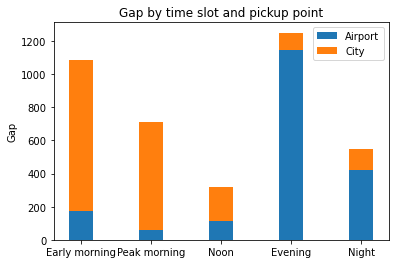

In [101]:
labels = gap_df['Request Time Slot']
gap_airport = gap_df['Gap_From_Airport']
gap_city = gap_df['Gap_From_City']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, gap_airport, width, label='Airport')
ax.bar(labels, gap_city, width, bottom=gap_airport,
       label='City')

ax.set_ylabel('Gap')
ax.set_title('Gap by time slot and pickup point')
ax.legend()

plt.show()

We can clearly see that gap is maximum for Airport rides in evening hours and for City rides in early morning hours.

<br></br>
<b>Plotting demand and supply for all time slots as calculated in gap_df dataframe.</b>

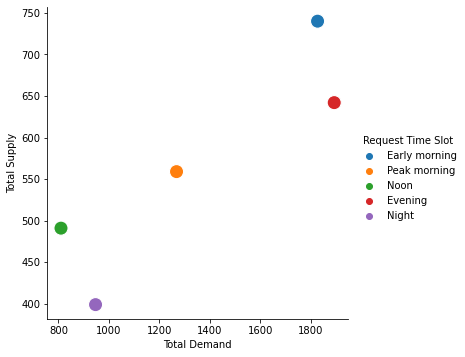

In [102]:
demandVsGap = sns.pairplot(gap_df,x_vars='Total Demand', y_vars='Total Supply',hue='Request Time Slot',plot_kws = {'alpha': 1, 's': 200},
             height = 5)

Metric figures calculated in gap_df can be visualized in above plot.<br></br>
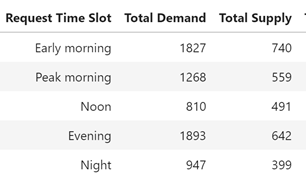

<br></br>
<b>Plotting demand-supply for City to Airport rides.</b>

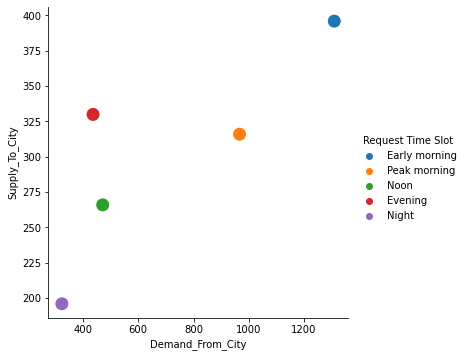

In [103]:
citytVsGap = sns.pairplot(gap_df,x_vars='Demand_From_City', y_vars='Supply_To_City',hue='Request Time Slot',plot_kws = {'alpha': 1, 's': 200},
             height = 5)

Numbers calculated in gap_df for City demand-supply can be visualized in above plot.<br></br>
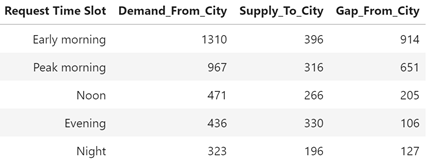

<br></br>
<b>Plotting demand-supply for Airport to City rides.</b>

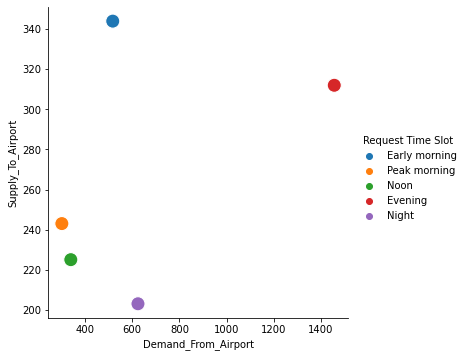

In [104]:
airporttVsGap = sns.pairplot(gap_df,x_vars='Demand_From_Airport', y_vars='Supply_To_Airport',hue='Request Time Slot',plot_kws = {'alpha': 1, 's': 200},
             height = 5)

Numbers calculated in gap_df for Airport demand-supply can be visualized in above plot.<br></br>
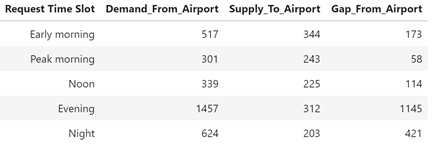

<br></br>
<b>Percentage wise distribution of rides for City and airport pickup points (Early morning hours and Evening hours).</b>

In [105]:
def pie_chart(dataframe):
    """
    creates a pie chart
    input: dataframe with a 'category' as index and a numerical column
    output: pie chart
    """
    labels = dataframe.index.values
    sizes = dataframe['Status'].values
        
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

<br></br>
Distribution of trips for pickup point as City during evening hours.

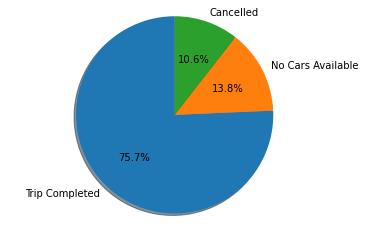

In [106]:
df_city = df_city_request.loc[df_city_request['Request Time Slot'] == "Evening hours"]
df_city_count = pd.DataFrame(df_city.Status.value_counts())
pie_chart(df_city_count)

<br></br>
Distribution of trips for pickup point as Airport during evening hours.

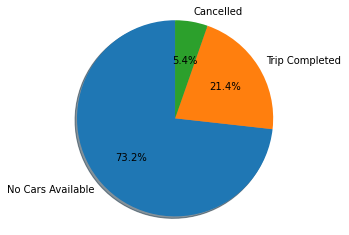

In [107]:
df_airport = df_airport_request.loc[df_airport_request["Request Time Slot"] == "Evening hours"]
df_airport_count = pd.DataFrame(df_airport.Status.value_counts())
pie_chart(df_airport_count)

Evening hours(Pickup point - Airport):
* 73% of total airport rides ended with 'No cars available'.
* Only 21% of airport trips were completed successfuly. 

<br></br>
Distribution of trips for pickup point as City during early morning hours.

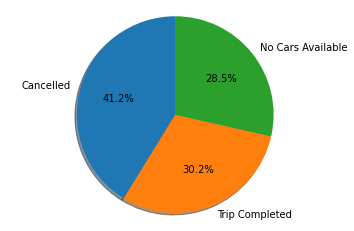

In [108]:
df_city = df_city_request.loc[df_city_request["Request Time Slot"] == "Early morning hours"]
df_city_count = pd.DataFrame(df_city.Status.value_counts())
pie_chart(df_city_count)

Early morning hours(Pickup point - City):
* 41% of city rides were cancelled by drivers.
* Only 30.2% of city trips were completed successfuly. 

<br></br>
Distribution of trips for pickup point as Airport during early morning hours.

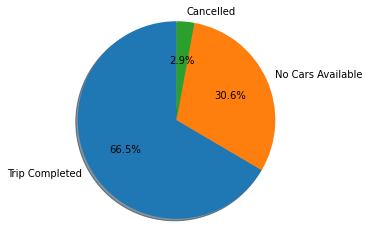

In [109]:
df_airport = df_airport_request.loc[df_airport_request["Request Time Slot"] == "Early morning hours"]
df_airport_count = pd.DataFrame(df_airport.Status.value_counts())
pie_chart(df_airport_count)

In [110]:
#Exporting final uber data set to CSV for tableau plotting
uberdata.to_csv("Uber Data.csv")

In [111]:
#Exporting final gap data set to CSV for tableau plotting
gap_df.to_csv("Gap Data.csv")

<br></br><b>Summary of results:</b>

* The most problematic request (e.g., city to airport / airport to city, etc.) and their time slots (e.g., early mornings, late evenings etc.)
  - In evening hours 73% of total airport rides ended with 'No cars available'.
  <br></br>
* Find the gap between supply and demand for different time slots. Also determine the time slot where maximum gap exists. 

    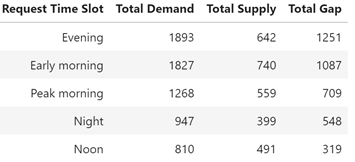
  <br></br>
* Find the type of requests (e.g., city to airport or airport to city) for which the gap is the most severe in the identified time slots.
  - Gap is highest for airport to city rides in evening hours.(1145)
  - Gap is highest for city to airport rides in early morning hours.(914)
  <br></br>
* Possible reasons behind the supply-demand gap.
  - Trips to and from an airport resulted in high consumption of fuel and time. Hence, a trip back to the city without a rider is not economically beneficial for the driver. 
  - Due to high variance in flight arrivals (higher during evening, late night hours) the driver idle time at airport is higher in morning hours. As a result, no cars are available in the city region.
  <br></br>
* Possible resolutions.
  - For the trips in the morning, drivers can be incentivised to make those trips, Uber can pay for the gas mileage of drivers to come back to the city without a ride.
  - For the evening, since the number of drivers is less, Uber can also pay drivers to come without a passenger to the airport.
  This section is discussed more in summary analysis.